# Stress Analysis in Social Media

Leverage the newly published and labelled reddit dataset for stress analysis to develop and improve supervised learning methods for identifying stress, both neural and traditional, and analyze the complexity and diversity of the data and characteristics of each category.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.corpus import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from wordcloud import WordCloud

## EDA

In [3]:
path = '../data/'
train = pd.read_csv(path + 'dreaddit-train.csv', encoding = "ISO-8859-1")
test = pd.read_csv(path + 'dreaddit-test.csv', encoding = "ISO-8859-1")

In [4]:
domain = {'domesticviolence':'abuse',
          'survivorsofabuse':'abuse',
          'anxiety': 'anxiety',
          'stress': 'anxiety', 
          'almosthomeless': 'financial',
          'assistance': 'financial',
          'food_pantry': 'financial', 
          'homeless': 'financial',
          'ptsd': 'ptsd',
          'relationships': 'social'}

train['domain'] = train['subreddit'].map(domain)
test['domain'] = test['subreddit'].map(domain)

In [8]:
print('Number of train data', len(train))
sns.countplot('label', data = train, palette='PRGn')

Number of train data 2838


TypeError: countplot() got multiple values for argument 'data'

In [6]:
print('Number of train data', len(test))
sns.countplot('label', data = test, palette='PRGn')

Number of train data 715


TypeError: countplot() got multiple values for argument 'data'

When doing the presentation, can add a part of analyzing the text with lexicon-based tool such as textblob

c:\Users\giahy\anaconda3\envs\new_env\lib\site-packages\ipykernel_launcher.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
c:\Users\giahy\anaconda3\envs\new_env\lib\site-packages\ipykernel_launcher.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  if __name__ == "__main__":


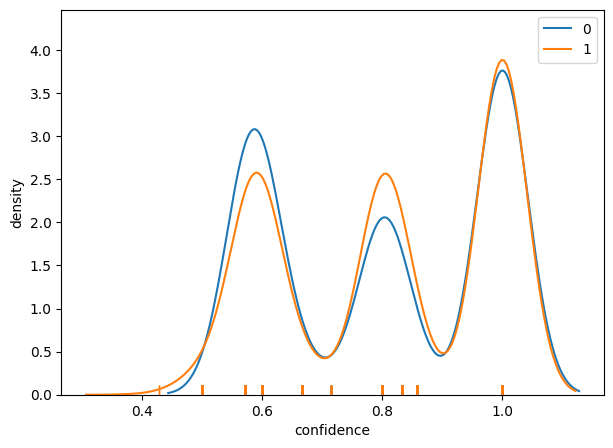

In [7]:
train[['label', 'confidence']]

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

label_0 = train.loc[train['label'] == 0]
label_1 = train.loc[train['label'] == 1]

sns.distplot(label_0[['confidence']], hist=False, rug=True, ax=ax, label=0)
sns.distplot(label_1[['confidence']], hist=False, rug=True, ax=ax, label=1)

ax.legend() 
ax.set_xlabel('confidence')
ax.set_ylabel('density')
plt.show()

## Data Preprocessing
Possible approach of data preprocessing and feature engineeing 
- Tokenization, Removal of punctuations.
- Removal of commonly used words (stopwords).
- Lemmatization or Stemming (Normalization)

### Tokenization & Remove punctuations
remove punctuations, single letter word, word that contains number...

In [10]:
# tokenization: breaks the string into list of words
tokenizer = RegexpTokenizer(r'[a-zA-Z]{2,}')
train['processed_text'] = train['text'].apply(lambda x: tokenizer.tokenize(x.lower()))
test['processed_text'] = test['text'].apply(lambda x: tokenizer.tokenize(x.lower()))

### Remove Stopwords

In [11]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [12]:
from tqdm import tqdm

In [13]:
tqdm.pandas()
train['processed_text'] = train['processed_text'].progress_apply(lambda x: remove_stopwords(x))

100%|██████████| 2838/2838 [01:14<00:00, 38.11it/s]


In [14]:
test['processed_text'] = test['processed_text'].apply(lambda x: remove_stopwords(x))

### Stemming & Lemmatization
Text normalization

In [15]:
%%
# stemming
stemmer = PorterStemmer()

def word_stemmer(text):
    stem_text = [stemmer.stem(i) for i in text]
    return stem_text

train['processed_text'] = train['processed_text'].apply(lambda x: word_stemmer(x))
test['processed_text'] = test['processed_text'].apply(lambda x: word_stemmer(x))

UsageError: Cell magic `%%` not found.


In [16]:
# lemmatization
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

train['processed_text'] = train['processed_text'].apply(lambda x: word_lemmatizer(x))
test['processed_text'] = test['processed_text'].apply(lambda x: word_lemmatizer(x))

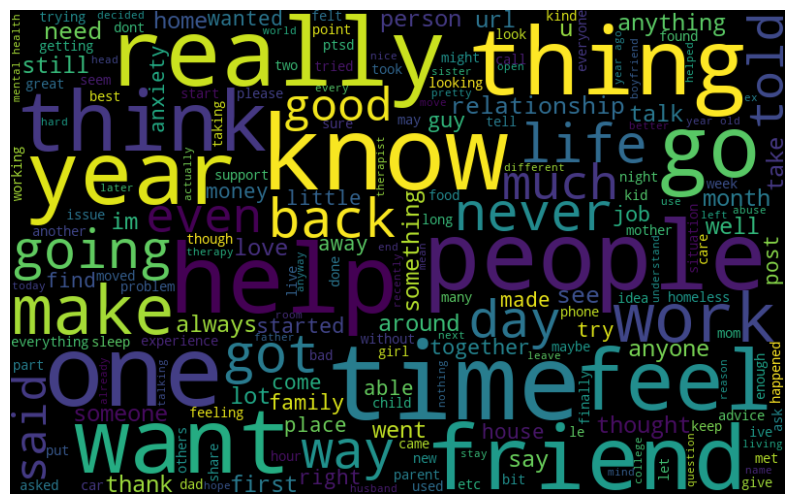

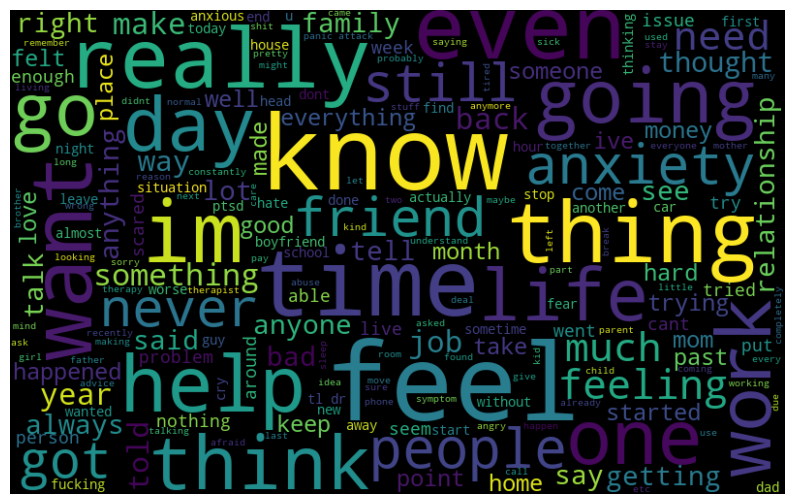

In [17]:
def create_word_cloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

train['processed_text'] = train['processed_text'].apply(lambda x: ' '.join(x))
non_stress_post_words = ' '.join([text for text in train[train['label'] == 0]['processed_text']])
stress_post_words = ' '.join([text for text in train[train['label'] == 1]['processed_text']])

create_word_cloud(non_stress_post_words)
create_word_cloud(stress_post_words)

In [18]:
train['text'].iloc[0]

'He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI\'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f\'n worried about my heart. I do happen to have a physical in 48 hours.'

In [19]:
train['processed_text'].iloc[0]

'said felt way suggeted go rest trigger ahead youi hypocondriac like decide look feeling doom hope maybe getting sucked rabbit hole ludicrous conspiracy stupid psychic test new age something could even laugh road ended reading sense doom indicative various health ailment one prone top doom gloom worried heart happen physical hour'

## Feature Extraction
- vectorization
- bag-of-n-grams
- tf-idf
- word2vec
- word embedding (pretrained
- fasttext 
- glove 

### TF-IDF
Find TF-IDF of unigram, bigram and trigram

#### Unigram

In [20]:
train_corpus = train['processed_text']

test['processed_text'] = test['processed_text'].apply(lambda x: ' '.join(x))
test_corpus = test['processed_text']

In [21]:
X = train_corpus.append(test_corpus)
X = X.reset_index(drop=True)

In [22]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1)) #unigram, bigram, trigram
X_new = vectorizer.fit_transform(X)

X_train = X_new.toarray()[:len(train)]
X_test = X_new.toarray()[len(train):]

In [23]:
print(X_train.shape)
print(X_test.shape)

(2838, 10716)
(715, 10716)


In [24]:
def top_tfidf_features(row, features, top_n):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_features = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_features)
    df.columns = ['feature', 'tfidf']
    return df

def top_features_in_post(data, features, row_id, top_n):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(data[row_id])
    return top_tfidf_features(row, features, top_n)

In [25]:
features = vectorizer.get_feature_names()
top_features_in_post(X_train, features, 0, 10)

c:\Users\giahy\anaconda3\envs\new_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,tfidf
0,doom,0.516057
1,indicative,0.187326
2,youi,0.187326
3,conspiracy,0.187326
4,hypocondriac,0.187326
5,ludicrous,0.187326
6,suggeted,0.187326
7,gloom,0.187326
8,ailment,0.178372
9,psychic,0.172019


In [26]:
def top_mean_features_by_label(X, y, features, top_n, label_id):
    ids = np.where(y == label_id)
    
    if ids:
        new_data = X[ids]
    else:
        new_data = X


    tfidf_means = np.mean(new_data, axis=0)
    feature_df = top_tfidf_features(tfidf_means, features, top_n)
    feature_df['label'] = label_id

    return feature_df    

In [28]:
non_stress_df = top_mean_features_by_label(X_train, train['label'], features, 200, 0)
stress_df = top_mean_features_by_label(X_train, train['label'], features, 200, 1)

ValueError: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of ticklabels (200).

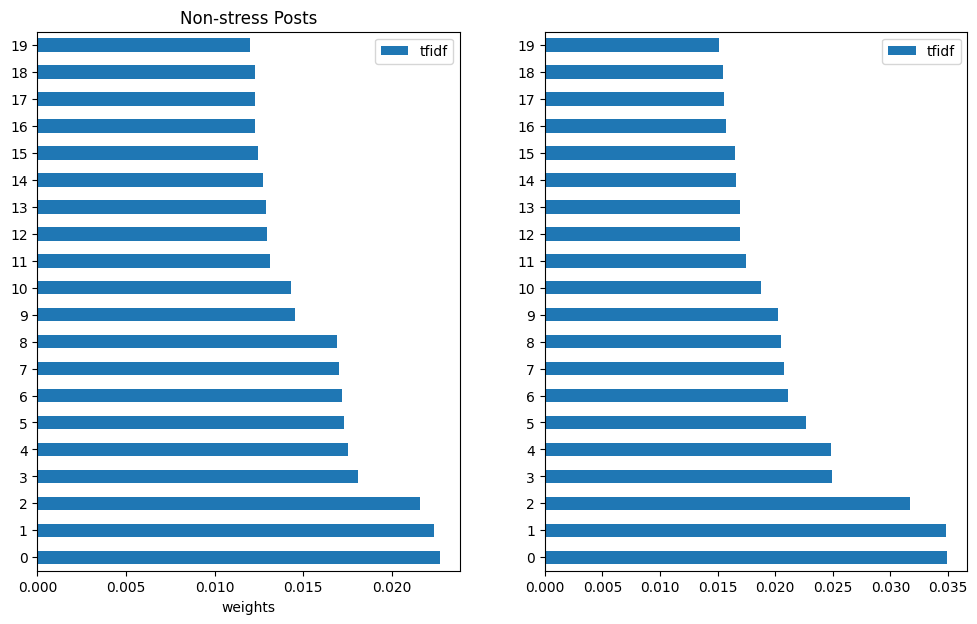

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
non_stress_df[['feature', 'tfidf']][:20].plot(kind='barh', ax=ax[0])
stress_df[['feature', 'tfidf']][:20].plot(kind='barh', ax=ax[1])

ax[0].set_title('Non-stress Posts')
ax[0].set_xlabel('weights')
ax[0].set_yticklabels(non_stress_df.feature)

ax[1].set_title('Stress Posts')
ax[1].set_xlabel('weights')
ax[1].set_yticklabels(stress_df.feature)


fig.suptitle('TF-IDF Top 20 words')
plt.subplots_adjust(wspace = 0.5)
plt.show()

In [30]:
def create_tfidf_word_cloud(weights):
    wc = WordCloud(width=800, height=500, random_state=21, max_font_size=110)
    wordcloud = wc.generate_from_frequencies(weights)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

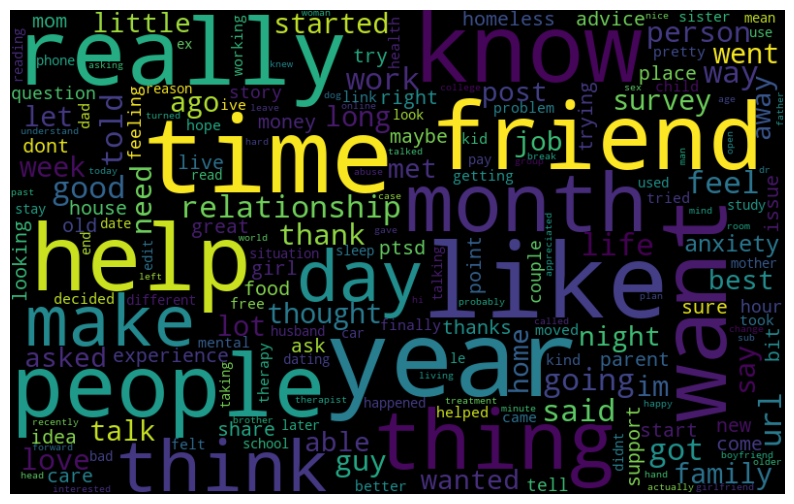

In [31]:
non_stress_weights = dict(zip(non_stress_df.feature, non_stress_df.tfidf))
create_tfidf_word_cloud(non_stress_weights)

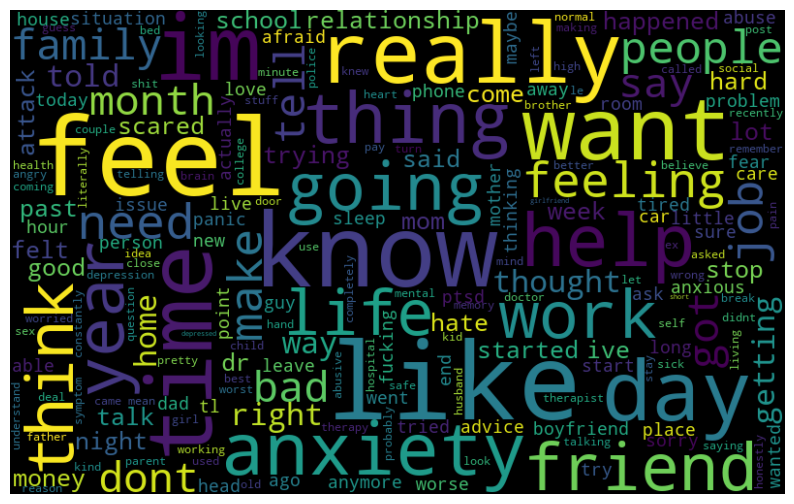

In [32]:
stress_weights = dict(zip(stress_df.feature, stress_df.tfidf))
create_tfidf_word_cloud(stress_weights)

#### 1~3-gram

In [33]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3)) #unigram, bigram, trigram
X_new = vectorizer.fit_transform(X)
X_train = X_new.toarray()[:len(train)]
X_test = X_new.toarray()[len(train):]

features = vectorizer.get_feature_names()

non_stress_df = top_mean_features_by_label(X_train, train['label'], features, 200, 0)
stress_df = top_mean_features_by_label(X_train, train['label'], features, 200, 1)

c:\Users\giahy\anaconda3\envs\new_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


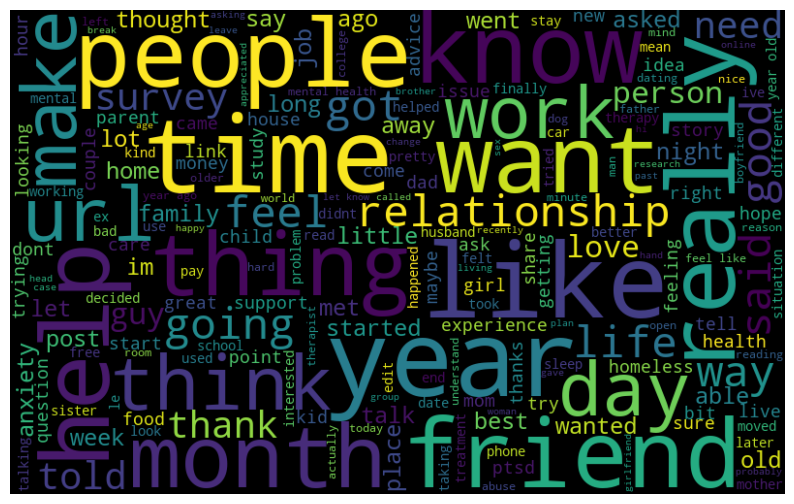

In [34]:
non_stress_weights = dict(zip(non_stress_df.feature, non_stress_df.tfidf))
create_tfidf_word_cloud(non_stress_weights)

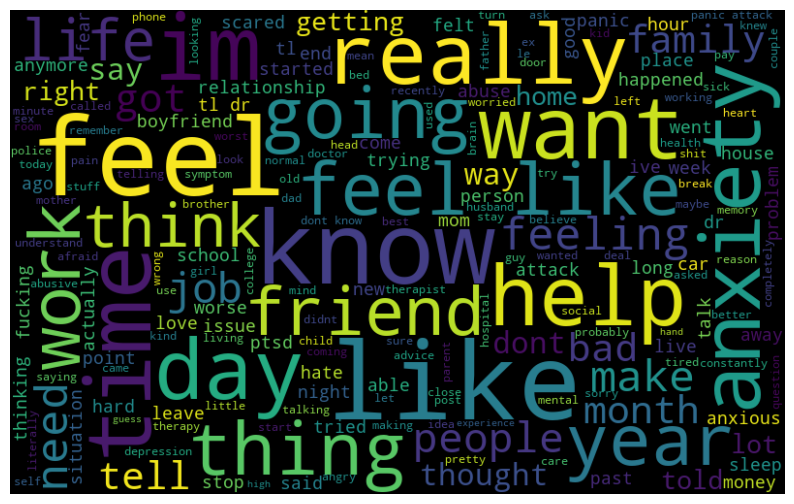

In [35]:
stress_weights = dict(zip(stress_df.feature, stress_df.tfidf))
create_tfidf_word_cloud(stress_weights)

## Classification
### TF-IDF with NLP Classifiers (1-gram)

In [36]:
y_train = train['label']
y_test = test['label']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [37]:
clf_dict = {'log reg': LogisticRegression(random_state=42), 
            'naive bayes': GaussianNB(), 
            'linear svc': LinearSVC(random_state=42),
            'CART': DecisionTreeClassifier(random_state=42),
            'random forest': RandomForestClassifier(n_estimators=100, random_state=42)}

In [38]:
for name, clf in clf_dict.items():
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of {}:'.format(name), accuracy_score(y_pred, y_test))

Accuracy of log reg: 0.7062937062937062
Accuracy of naive bayes: 0.6125874125874126
Accuracy of linear svc: 0.7314685314685314
Accuracy of CART: 0.6111888111888112
Accuracy of random forest: 0.6979020979020979


In [39]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7062937062937062

#### Classification Result
Visualize the results 
- Confusion Matrix (precision, recall...)
- TSNE
- Word Cloud (different domains' important words)

<AxesSubplot:>

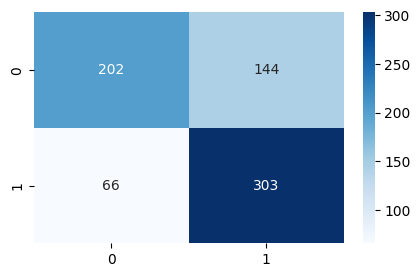

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [41]:
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('F1-Score', f1_score(y_test, y_pred))

Precision 0.6778523489932886
Recall 0.8211382113821138
F1-Score 0.7426470588235294


### TF-IDF with NLP Classifiers (1/2/3-gram)

In [42]:
# %%
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

for name, clf in clf_dict.items():
    model = clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of {}:'.format(name), accuracy_score(y_pred, y_test))

Accuracy of log reg: 0.7062937062937062
Accuracy of naive bayes: 0.6125874125874126
Accuracy of linear svc: 0.7314685314685314
Accuracy of CART: 0.6111888111888112
Accuracy of random forest: 0.6979020979020979


In [43]:
clf = LinearSVC(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7314685314685314

<AxesSubplot:>

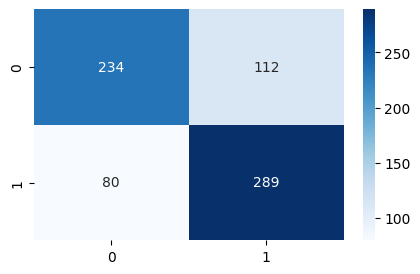

In [44]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [45]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7062937062937062

<AxesSubplot:>

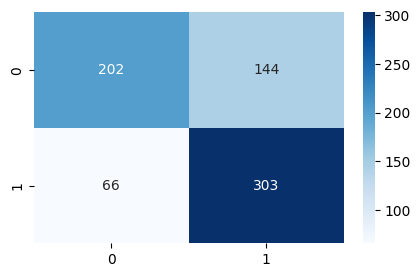

In [46]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (5, 3))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [47]:
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('F1-Score', f1_score(y_test, y_pred))

Precision 0.6778523489932886
Recall 0.8211382113821138
F1-Score 0.7426470588235294
